In [ ]:
#pandas - they standard data manipulation package
import pandas as pd
#numpy - scientific computation - matrix operations, etc.
import numpy as np
#for feature selection
from sklearn import feature_selection
import os

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir("gdrive/My Drive/mmf_course") 


In [0]:
train = pd.read_csv('application_train.csv')

#Kaggle question: should we be pre-splitting our data into train / test at this stage?

In [3]:
#Some EDA:

# checking missing data
total_null = train.isnull().count()
percent = (train.isnull().sum()/train.isnull().count()*100)
missing_check  = pd.concat([total_null, percent], axis=1, keys=['Total Null', 'Percent']).sort_values(ascending = False, by = ['Percent'])
missing_check.head(10)

#Sanity check - does it make sense for these to be missing?

,Total Null,Percent
COMMONAREA_MEDI,307511,69.872297
COMMONAREA_AVG,307511,69.872297
COMMONAREA_MODE,307511,69.872297
NONLIVINGAPARTMENTS_MODE,307511,69.432963
NONLIVINGAPARTMENTS_AVG,307511,69.432963
NONLIVINGAPARTMENTS_MEDI,307511,69.432963
FONDKAPREMONT_MODE,307511,68.386172
LIVINGAPARTMENTS_MODE,307511,68.354953
LIVINGAPARTMENTS_AVG,307511,68.354953
LIVINGAPARTMENTS_MEDI,307511,68.354953


In [0]:
#Let's define a function for our data exploration - a KDE plot

def kde_plot (df, var_name):
    plt.figure(figsize = (12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')

    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend()

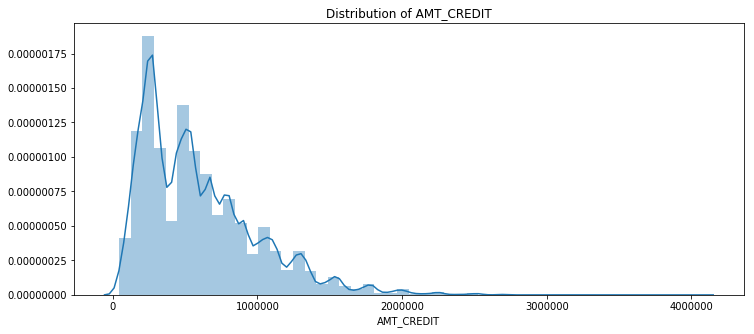

In [0]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(train["AMT_CREDIT"])

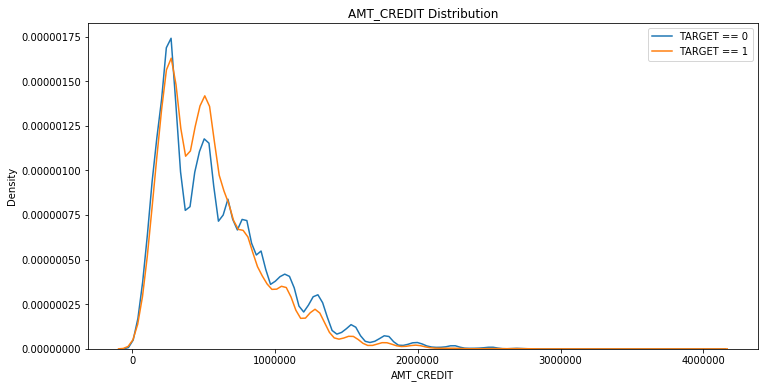

In [0]:
kde_plot(train, 'AMT_CREDIT')

In [0]:
#for categorical variables, we can just visualize in a bar chart (or table)

def pop_rate (target):
    return target.sum() / target.count()


train.groupby('NAME_TYPE_SUITE').agg({'TARGET': [pop_rate, 'count']})

TARGET        
                 pop_rate   count
NAME_TYPE_SUITE                  
Children         0.073768    3267
Family           0.074946   40149
Group of people  0.084871     271
Other_A          0.087760     866
Other_B          0.098305    1770
Spouse, partner  0.078716   11370
Unaccompanied    0.081830  248526

In [0]:
#read in additional data - cash balance

cash_balance = pd.read_csv ('credit_card_balance.csv')

In [0]:
#inspect our data

cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [0]:
#Feature ideas?

In [0]:
#cash_balance[["MONTHS_BALANCE", "AMT_BALANCE"]] = cash_balance[["MONTHS_BALANCE", "AMT_BALANCE"]].apply(pd.to_numeric)


cash_balance_feats = cash_balance.groupby('SK_ID_CURR') \
  .apply(lambda x: pd.Series({
      'amt_balance': x['AMT_BALANCE'].sum(),
      'amt_balance_0_1_year': x['AMT_BALANCE'][x['MONTHS_BALANCE'] >= -12].sum(),
      'amt_balance_1_2_year': x['AMT_BALANCE'][(x['MONTHS_BALANCE'] < -12) & (x['MONTHS_BALANCE'] >= -24)].sum()
  })
)



In [0]:
#spot check our results
cash_balance_feats.head(n=20)

,amt_balance,amt_balance_0_1_year,amt_balance_1_2_year
SK_ID_CURR,,,
100006,0.000,0.000,0.000
100011,4031676.225,0.000,0.000
100013,1743352.245,0.000,0.000
100021,0.000,0.000,0.000
100023,0.000,0.000,0.000
100028,396167.850,131561.010,105494.670
100036,0.000,0.000,0.000
100042,2801919.375,0.000,0.000
100043,6882895.800,0.000,3293125.875


In [0]:
#Spot-check the calculation (QA)

cash_balance.sort_values(by=['MONTHS_BALANCE'],ascending=False)[cash_balance['SK_ID_CURR']==100028]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
617886,1914954,100028,-1,37335.915,225000,0.0,22823.550,0.0,22823.550,11250.000,...,36980.415,36980.415,0.0,4,0.0,4.0,35.0,Active,0,0
1660670,1914954,100028,-2,24710.085,225000,0.0,15009.615,0.0,15009.615,11250.000,...,24354.585,24354.585,0.0,9,0.0,9.0,34.0,Active,0,0
1835811,1914954,100028,-3,20221.830,225000,0.0,19867.500,0.0,19867.500,0.000,...,19866.330,19866.330,0.0,9,0.0,9.0,33.0,Active,0,0
1561465,1914954,100028,-4,0.000,225000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
1460388,1914954,100028,-5,0.000,225000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
1272681,1914954,100028,-6,0.000,225000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
1498585,1914954,100028,-7,0.000,225000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
1384907,1914954,100028,-8,0.000,225000,0.0,0.000,0.0,0.000,6438.330,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
3060632,1914954,100028,-9,6438.330,225000,0.0,5996.835,0.0,5996.835,7855.110,...,6082.830,6082.830,0.0,3,0.0,3.0,32.0,Active,0,0
2466412,1914954,100028,-10,7888.545,225000,0.0,0.000,0.0,0.000,11250.000,...,7533.045,7533.045,0.0,0,0.0,0.0,31.0,Active,0,0


In [0]:
#look at aggregates - another quick QA

cash_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


In [0]:
# Join to the training dataframe
train = train.merge(cash_balance_feats, on = 'SK_ID_CURR', how = 'left')

for col_name in ['amt_balance', 'amt_balance_0_1_year', 'amt_balance_1_2_year']:
    train[col_name] = train[col_name].fillna(0)

# Fill the missing values with 0 
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,amt_balance,amt_balance_0_1_year,amt_balance_1_2_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


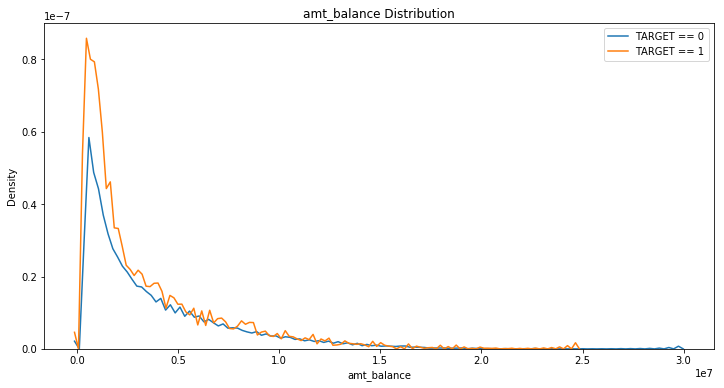

In [0]:
#Is our new feature any good?

kde_plot(train, 'amt_balance')

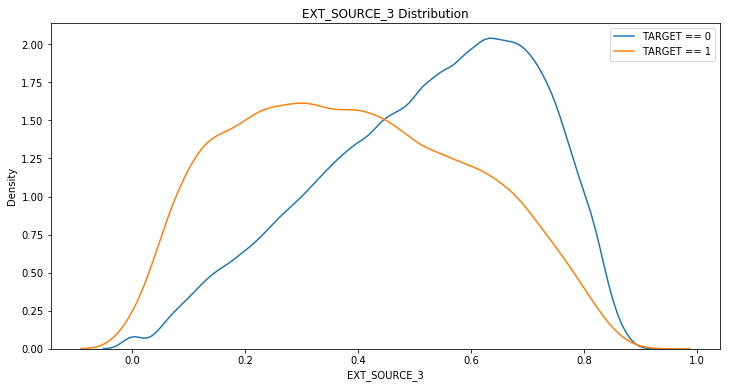

In [0]:
#How about this one?

kde_plot(train, 'EXT_SOURCE_3')

In [0]:
#one-hot encode the categorical variables

train_factorized = pd.get_dummies(train)


#let's pad the rest with 0's (for now)
#clean up infinite values also - just in case

train_factorized.replace([np.inf, -np.inf], np.nan)

for col in list(train_factorized.columns):
    train_factorized[col].fillna(0, inplace = True)
    



In [0]:
#Downsample our data (stratified) for speed 

train_compute_mi_sample = train_factorized[train_factorized['TARGET'] ==1]
train_compute_mi_sample = train_compute_mi_sample.append(train_factorized[train_factorized['TARGET'] ==0].sample(frac = 0.1, replace = False))


In [0]:
#and QA!

print(train_factorized.shape, train_compute_mi_sample.shape)

(307511, 249) (53094, 249)


In [0]:
#Exercise - make + explore more features

In [0]:
#train a baseline model

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pylab as plt
import gc




In [0]:
#Sampling for speed only 

Training Data Shape:  (53094, 247)


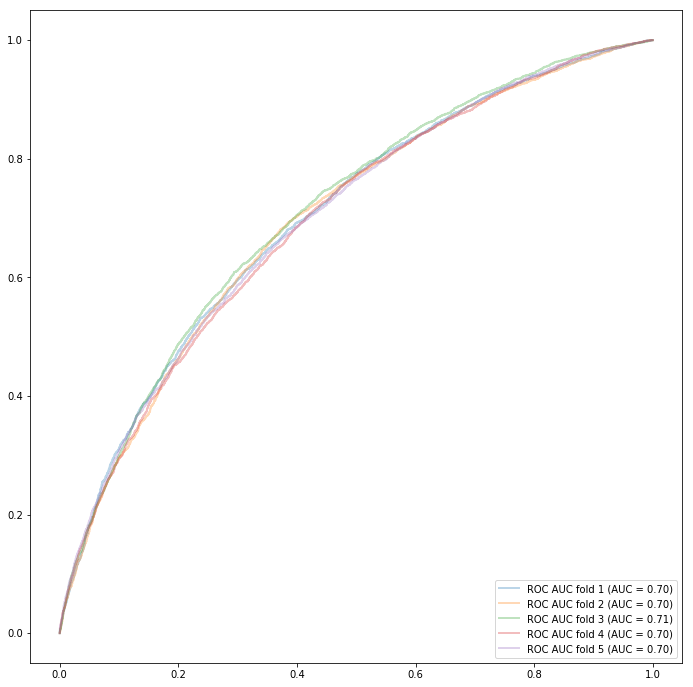

In [0]:
#do k-fold



# make plot
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

# Extract the ids
ids = train_compute_mi_sample['SK_ID_CURR']

# Extract the labels for training
labels = train_compute_mi_sample['TARGET']


features = train_compute_mi_sample.drop(columns = ['SK_ID_CURR', 'TARGET'])

print('Training Data Shape: ', features.shape)

# Extract feature names
feature_names = list(features.columns)

# Convert to np arrays
training_matrix = np.array(features)

# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 50)

#make our model object
model = RandomForestClassifier(n_estimators=100, 
                               max_depth = 3, min_samples_split = 200, min_samples_leaf = 50)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

tprs = []
aucs = []


#fold counter
i=1

for train,test in k_fold.split(features,labels):
    prob = model.fit(features.iloc[train],labels.iloc[train]).predict_proba(features.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(labels.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC AUC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.legend(loc="lower right")
plt.show()

In [0]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

In [0]:
kmeans = KMeans(n_clusters=10,
                    init= 'k-means++', # smart way of selecting initial clusters to speed up the process
                    max_iter = 300,
                    n_init = 10, # num centroid seeds
                    random_state = 123)
kmeans_results = kmeans.fit(features)

In [0]:
train_clusters = pd.DataFrame(data = {"cluster": kmeans_results.predict(features)}
             ,index = features.index)
onehotencoder = OneHotEncoder()
one_hotted_train_data = pd.DataFrame(
    data = onehotencoder.fit_transform(train_clusters[["cluster"]]).toarray()
    ,index = train_clusters.index)
assert features.shape[0] == one_hotted_train_data.shape[0], "shape is off"
features_with_kmeans = features.join(one_hotted_train_data)

In [0]:
features_with_kmeans.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,0,1,2,3,4,5,6,7,8,9
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0,112500.0,979992.0,27076.5,702000.0,0.018029,-18724,-2628,-6573.0,-1827,0.0,1,1,0,1,0,0,1.0,3,2,9,0,0,0,0,0,0,0.000000,0.548477,0.190706,0.0165,0.0089,0.9732,0.0000,0.0000,0.00,0.0690,0.0417,0.0000,0.0265,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0,202500.0,1193580.0,35028.0,855000.0,0.025164,-17482,-1262,-1182.0,-1029,0.0,1,1,0,1,0,0,2.0,2,2,9,0,0,0,0,0,0,0.000000,0.306841,0.320163,0.1309,0.1250,0.9960,0.9456,0.0822,0.16,0.1379,0.2500,0.2917,0.0142,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0,135000.0,288873.0,16258.5,238500.0,0.007305,-13384,-3597,-45.0,-4409,0.0,1,1,1,1,1,0,2.0,3,3,11,0,0,0,0,0,0,0.468208,0.674203,0.399676,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0,81000.0,252000.0,14593.5,252000.0,0.028663,-24794,365243,-5391.0,-4199,0.0,1,0,0,1,0,0,2.0,2,2,10,0,0,0,0,0,0,0.000000,0.023952,0.720944,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Training Data Shape:  (53094, 257)


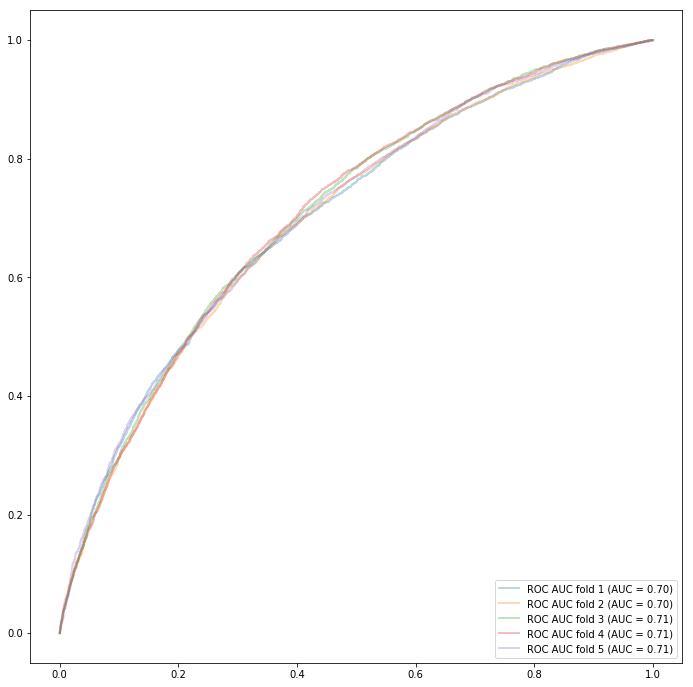

In [0]:
#do k-fold



# make plot
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

# Extract the ids
ids = train_compute_mi_sample['SK_ID_CURR']

# Extract the labels for training
labels = train_compute_mi_sample['TARGET']


features = features_with_kmeans

print('Training Data Shape: ', features.shape)

# Extract feature names
feature_names = list(features.columns)

# Convert to np arrays
training_matrix = np.array(features)

# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 50)

#make our model object
model = RandomForestClassifier(n_estimators=100, 
                               max_depth = 3, min_samples_split = 200, min_samples_leaf = 50)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

tprs = []
aucs = []


#fold counter
i=1

for train,test in k_fold.split(features,labels):
    prob = model.fit(features.iloc[train],labels.iloc[train]).predict_proba(features.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(labels.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC AUC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.legend(loc="lower right")
plt.show()

In [0]:
###Exercise:

#Homework: what about if used to segment our models?
#Homework: more feature engineering

In [0]:
# Read in bureau
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [0]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg([np.mean, np.median,
                     np.min, np.max]).reset_index()
bureau_agg.head()

SK_ID_CURR  DAYS_CREDIT                ...  AMT_ANNUITY                     
                     mean  median  amin  ...         mean median amin     amax
0     100001  -735.000000  -857.0 -1572  ...  3545.357143    0.0  0.0  10822.5
1     100002  -874.000000 -1042.5 -1437  ...     0.000000    0.0  0.0      0.0
2     100003 -1400.750000 -1205.5 -2586  ...          NaN    NaN  NaN      NaN
3     100004  -867.000000  -867.0 -1326  ...          NaN    NaN  NaN      NaN
4     100005  -190.666667  -137.0  -373  ...  1420.500000    0.0  0.0   4261.5

[5 rows x 49 columns]

In [0]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [0]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_median,bureau_DAYS_CREDIT_amin,bureau_DAYS_CREDIT_amax,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_median,bureau_CREDIT_DAY_OVERDUE_amin,bureau_CREDIT_DAY_OVERDUE_amax,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_median,bureau_DAYS_CREDIT_ENDDATE_amin,bureau_DAYS_CREDIT_ENDDATE_amax,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_median,bureau_DAYS_ENDDATE_FACT_amin,bureau_DAYS_ENDDATE_FACT_amax,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_median,bureau_AMT_CREDIT_MAX_OVERDUE_amin,bureau_AMT_CREDIT_MAX_OVERDUE_amax,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_median,bureau_CNT_CREDIT_PROLONG_amin,bureau_CNT_CREDIT_PROLONG_amax,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_median,bureau_AMT_CREDIT_SUM_amin,bureau_AMT_CREDIT_SUM_amax,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_median,bureau_AMT_CREDIT_SUM_DEBT_amin,bureau_AMT_CREDIT_SUM_DEBT_amax,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_median,bureau_AMT_CREDIT_SUM_LIMIT_amin,bureau_AMT_CREDIT_SUM_LIMIT_amax,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_median,bureau_AMT_CREDIT_SUM_OVERDUE_amin,bureau_AMT_CREDIT_SUM_OVERDUE_amax,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_median,bureau_DAYS_CREDIT_UPDATE_amin,bureau_DAYS_CREDIT_UPDATE_amax,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_median,bureau_AMT_ANNUITY_amin,bureau_AMT_ANNUITY_amax
0,100001,-735.000000,-857.0,-1572,-49,0.0,0.0,0,0,82.428571,-179.0,-1329.0,1778.0,-825.500000,-715.0,-1328.0,-544.0,NaN,NaN,NaN,NaN,0.0,0.0,0,0,207623.571429,168345.00,85500.0,378000.0,85240.928571,0.0,0.0,373239.0,0.00000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,-93.142857,-155.0,-155,-6,3545.357143,0.0,0.0,10822.5
1,100002,-874.000000,-1042.5,-1437,-103,0.0,0.0,0,0,-349.000000,-424.5,-1072.0,780.0,-697.500000,-939.0,-1185.0,-36.0,1681.029,40.5,0.0,5043.645,0.0,0.0,0,0,108131.945625,54130.50,0.0,450000.0,49156.200000,0.0,0.0,245781.0,7997.14125,0.0,0.0,31988.565,0.0,0.0,0.0,0.0,-499.875000,-402.5,-1185,-7,0.000000,0.0,0.0,0.0
2,100003,-1400.750000,-1205.5,-2586,-606,0.0,0.0,0,0,-544.500000,-480.0,-2434.0,1216.0,-1097.333333,-621.0,-2131.0,-540.0,0.000,0.0,0.0,0.000,0.0,0.0,0,0,254350.125000,92576.25,22248.0,810000.0,0.000000,0.0,0.0,0.0,202500.00000,0.0,0.0,810000.000,0.0,0.0,0.0,0.0,-816.000000,-545.0,-2131,-43,NaN,NaN,NaN,NaN
3,100004,-867.000000,-867.0,-1326,-408,0.0,0.0,0,0,-488.500000,-488.5,-595.0,-382.0,-532.500000,-532.5,-683.0,-382.0,0.000,0.0,0.0,0.000,0.0,0.0,0,0,94518.900000,94518.90,94500.0,94537.8,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,-532.000000,-532.0,-682,-382,NaN,NaN,NaN,NaN
4,100005,-190.666667,-137.0,-373,-62,0.0,0.0,0,0,439.333333,122.0,-128.0,1324.0,-123.000000,-123.0,-123.0,-123.0,0.000,0.0,0.0,0.000,0.0,0.0,0,0,219042.000000,58500.00,29826.0,568800.0,189469.500000,25321.5,0.0,543087.0,0.00000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,-54.333333,-31.0,-121,-11,1420.500000,0.0,0.0,4261.5
